# Hilbert-Huang Transform (HHT) Features Demo

This notebook demonstrates how to use Hilbert-Huang Transform features for motor health monitoring.

## What is HHT?

The **Hilbert-Huang Transform** is a powerful signal processing technique that decomposes non-linear and non-stationary signals into **Intrinsic Mode Functions (IMFs)**. It's particularly useful for motor fault detection because:

1. **No assumptions**: Unlike FFT, doesn't assume signal is stationary or linear
2. **Adaptive decomposition**: Automatically finds natural oscillation modes
3. **Instantaneous features**: Captures time-varying frequency and amplitude
4. **Fault signatures**: Different IMFs can capture different types of faults

## Key HHT Features Extracted:

- **IMF Energy**: Energy distribution across different modes
- **Instantaneous Frequency**: Time-varying frequency content
- **Instantaneous Amplitude**: Time-varying amplitude envelope
- **Spectral Entropy**: Complexity of frequency distribution
- **Energy Distribution Entropy**: How energy is spread across IMFs

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from ml_toolbox.data_loader.feature_extraction import (
    FeatureConfig, 
    FeatureExtractor, 
    HilbertHuangFeatures,
    HHT_AVAILABLE
)

print(f"HHT Available: {HHT_AVAILABLE}")
if not HHT_AVAILABLE:
    print("Please install EMD-signal package: pip install EMD-signal")

HHT Available: True


## Step 1: Install Required Package

If HHT is not available, install the required package:

In [ ]:
# Uncomment and run this cell if EMD-signal is not installed
# !pip install EMD-signal

## Step 2: Create Test Signals

Let's create synthetic signals that mimic motor conditions:

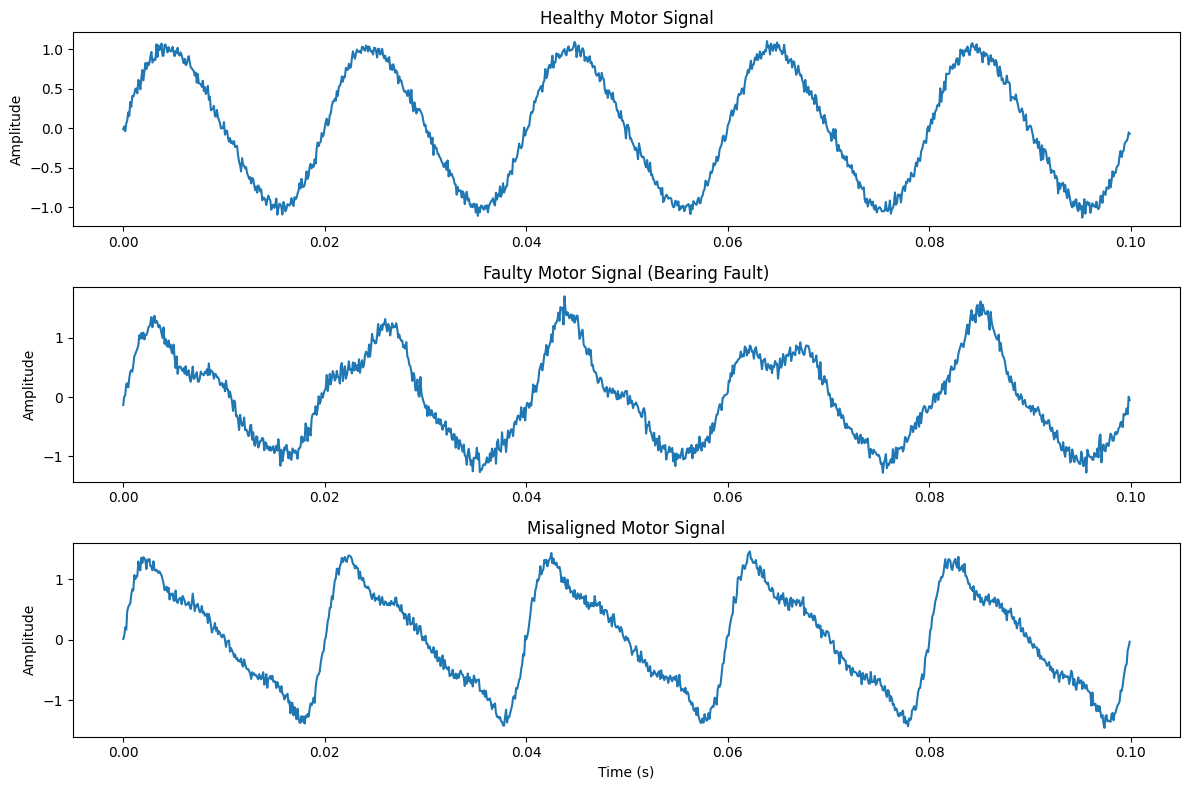

In [2]:
# Signal parameters
fs = 10000  # Sampling rate (same as current sensors)
t = np.linspace(0, 1, fs)  # 1 second of data

# Create different types of signals
def create_healthy_signal(t):
    """Healthy motor signal - mainly fundamental frequency"""
    f_fundamental = 50  # Motor fundamental frequency
    signal = (
        1.0 * np.sin(2 * np.pi * f_fundamental * t) +  # Fundamental
        0.1 * np.sin(2 * np.pi * 2 * f_fundamental * t) +  # 2nd harmonic
        0.05 * np.random.randn(len(t))  # Noise
    )
    return signal

def create_faulty_signal(t):
    """Faulty motor signal - modulated with fault frequencies"""
    f_fundamental = 50
    f_fault = 120  # Bearing fault frequency
    
    # Amplitude modulation due to fault
    modulation = 1 + 0.3 * np.sin(2 * np.pi * f_fault * t)
    
    signal = (
        modulation * np.sin(2 * np.pi * f_fundamental * t) +  # Modulated fundamental
        0.2 * np.sin(2 * np.pi * f_fault * t) +  # Fault frequency
        0.1 * np.sin(2 * np.pi * 2 * f_fundamental * t) +  # 2nd harmonic
        0.08 * np.random.randn(len(t))  # Noise
    )
    return signal

def create_misalignment_signal(t):
    """Misalignment signal - strong harmonics"""
    f_fundamental = 50
    signal = (
        1.0 * np.sin(2 * np.pi * f_fundamental * t) +  # Fundamental
        0.4 * np.sin(2 * np.pi * 2 * f_fundamental * t) +  # Strong 2nd harmonic
        0.3 * np.sin(2 * np.pi * 3 * f_fundamental * t) +  # Strong 3rd harmonic
        0.1 * np.sin(2 * np.pi * 4 * f_fundamental * t) +  # 4th harmonic
        0.06 * np.random.randn(len(t))  # Noise
    )
    return signal

# Generate test signals
healthy = create_healthy_signal(t)
faulty = create_faulty_signal(t)
misaligned = create_misalignment_signal(t)

# Plot signals
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].plot(t[:1000], healthy[:1000])
axes[0].set_title('Healthy Motor Signal')
axes[0].set_ylabel('Amplitude')

axes[1].plot(t[:1000], faulty[:1000])
axes[1].set_title('Faulty Motor Signal (Bearing Fault)')
axes[1].set_ylabel('Amplitude')

axes[2].plot(t[:1000], misaligned[:1000])
axes[2].set_title('Misaligned Motor Signal')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Step 3: Extract HHT Features

Now let's extract HHT features from these signals. **Good news**: HHT features are now **enabled by default** in FeatureConfig, so you don't need to explicitly set `hht_features=True`!

In [3]:
# Configure feature extraction with HHT enabled by default
config = FeatureConfig(
    sampling_rate=fs,
    time_domain=True,
    frequency_domain=True,
    # hht_features=True,  # Now enabled by default!
    max_imfs=6,  # Extract up to 6 IMFs
    ensemble_emd=True,  # Use EEMD for robustness
    emd_noise_std=0.2,  # Noise level for EEMD
    emd_trials=50  # Number of EEMD trials (reduced for speed)
)

# Create feature extractor
extractor = FeatureExtractor(config)

# Extract features from each signal
print("Extracting features...")
healthy_features = extractor.extract_features(healthy, "healthy")
faulty_features = extractor.extract_features(faulty, "faulty")
misaligned_features = extractor.extract_features(misaligned, "misaligned")

print(f"Extracted {len(healthy_features)} features per signal")

Extracting features...
Extracted 89 features per signal
Extracted 89 features per signal


## Step 4: Analyze HHT Features

Let's examine the HHT-specific features:

In [4]:
import pandas as pd

# Extract only HHT features for comparison
def get_hht_features(features, signal_name):
    hht_features = {}
    for key, value in features.items():
        if 'imf_' in key or 'hht_' in key or 'energy_distribution' in key or 'dominant_imf' in key or 'instantaneous_bandwidth' in key:
            # Remove signal prefix for cleaner comparison
            clean_key = key.replace(f'{signal_name}_', '')
            hht_features[clean_key] = value
    return hht_features

# Create comparison dataframe
hht_healthy = get_hht_features(healthy_features, 'healthy')
hht_faulty = get_hht_features(faulty_features, 'faulty')
hht_misaligned = get_hht_features(misaligned_features, 'misaligned')

comparison_df = pd.DataFrame({
    'Healthy': hht_healthy,
    'Faulty': hht_faulty,
    'Misaligned': hht_misaligned
})

print("HHT Features Comparison:")
print("=" * 50)
print(comparison_df.round(4))

HHT Features Comparison:
                               Healthy     Faulty  Misaligned
imf_1_energy                   15.1620    39.6569     22.8462
imf_1_mean_freq              1626.9786  1625.9809   1615.1724
imf_1_std_freq                772.7367   762.6686    793.6898
imf_1_mean_amplitude            0.0502     0.0806      0.0612
imf_1_std_amplitude             0.0226     0.0380      0.0286
imf_2_energy                    5.5422    14.9821      8.4752
imf_2_mean_freq              1646.3385  1613.9828   1626.1053
imf_2_std_freq                486.2710   500.4679    479.0082
imf_2_mean_amplitude            0.0299     0.0492      0.0370
imf_2_std_amplitude             0.0146     0.0241      0.0180
imf_3_energy                    2.8957     8.1895      3.9451
imf_3_mean_freq               973.8920   928.8723    916.5974
imf_3_std_freq                323.4127   334.4910    303.2728
imf_3_mean_amplitude            0.0215     0.0360      0.0248
imf_3_std_amplitude             0.0108     0.

## Step 5: Visualize Key HHT Features

Let's visualize the most discriminative HHT features:

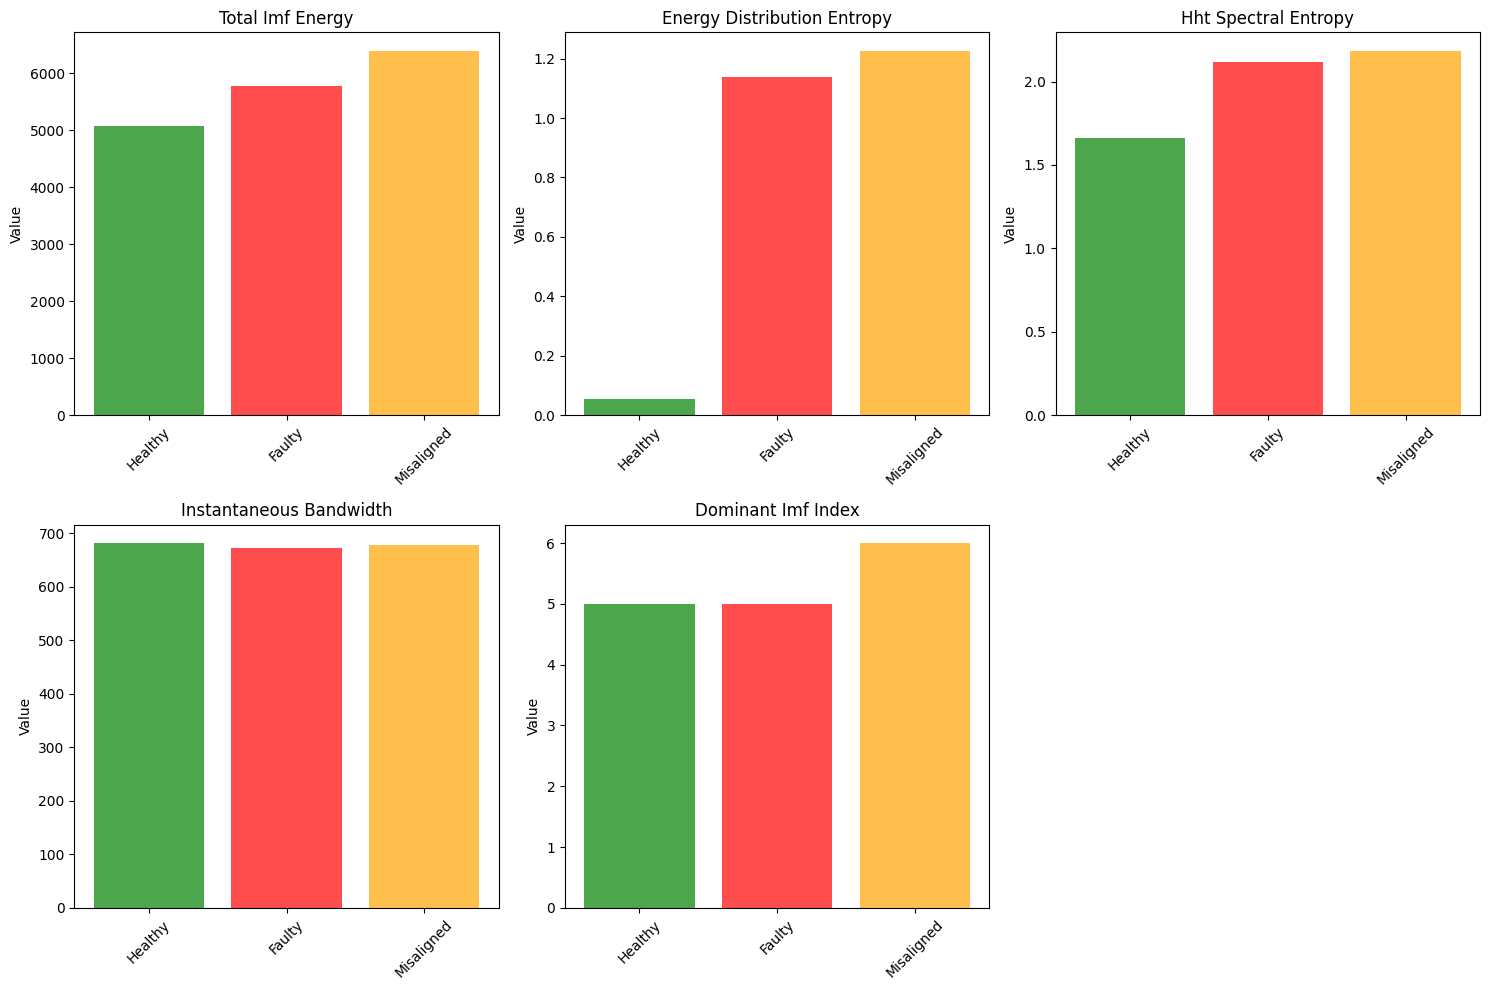


Key Insights from HHT Features:
total_imf_energy:
  Healthy: 5078.5032
  Faulty: 5769.9705
  Misaligned: 6397.1631

energy_distribution_entropy:
  Healthy: 0.0537
  Faulty: 1.1395
  Misaligned: 1.2269

hht_spectral_entropy:
  Healthy: 1.6586
  Faulty: 2.1169
  Misaligned: 2.1853

instantaneous_bandwidth:
  Healthy: 681.7246
  Faulty: 672.4921
  Misaligned: 678.0777

dominant_imf_index:
  Healthy: 5.0000
  Faulty: 5.0000
  Misaligned: 6.0000



In [5]:
# Select key HHT features for visualization
key_features = [
    'total_imf_energy',
    'energy_distribution_entropy', 
    'hht_spectral_entropy',
    'instantaneous_bandwidth',
    'dominant_imf_index'
]

# Extract values for plotting
conditions = ['Healthy', 'Faulty', 'Misaligned']
feature_data = {}

for feature in key_features:
    if feature in comparison_df.index:
        feature_data[feature] = [
            comparison_df.loc[feature, 'Healthy'],
            comparison_df.loc[feature, 'Faulty'], 
            comparison_df.loc[feature, 'Misaligned']
        ]

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (feature_name, values) in enumerate(feature_data.items()):
    if i < len(axes):
        axes[i].bar(conditions, values, color=['green', 'red', 'orange'], alpha=0.7)
        axes[i].set_title(f'{feature_name.replace("_", " ").title()}')
        axes[i].set_ylabel('Value')
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplot
if len(feature_data) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print("\nKey Insights from HHT Features:")
print("=" * 40)
for feature_name, values in feature_data.items():
    print(f"{feature_name}:")
    print(f"  Healthy: {values[0]:.4f}")
    print(f"  Faulty: {values[1]:.4f}")
    print(f"  Misaligned: {values[2]:.4f}")
    print()

## Step 6: IMF Energy Distribution Analysis

Let's analyze how energy is distributed across different IMFs:

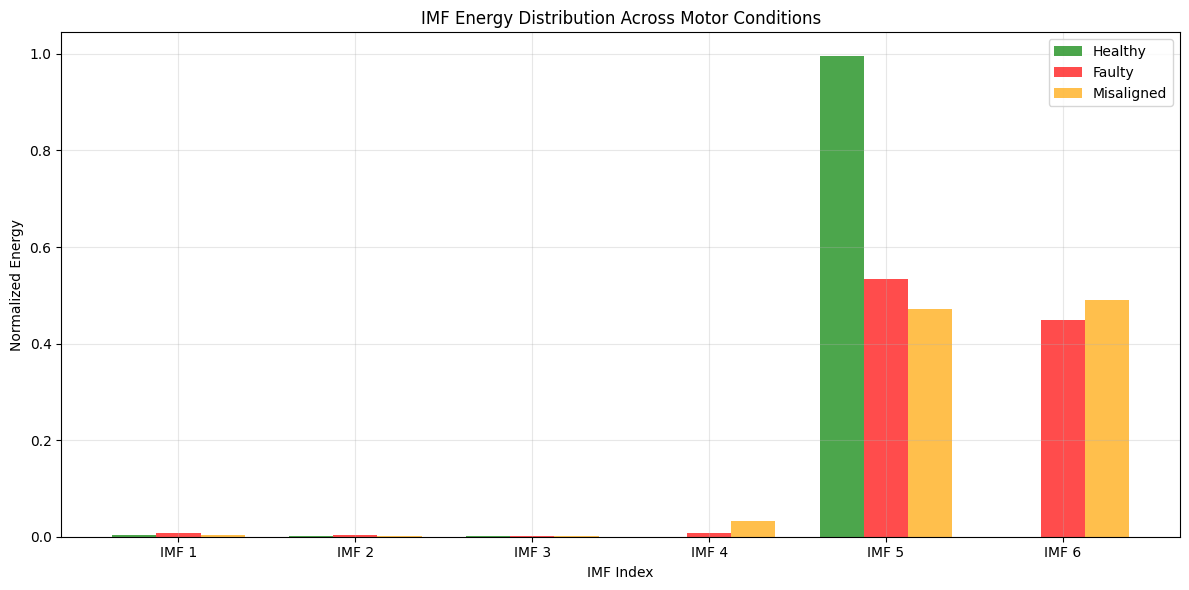


IMF Energy Distribution Analysis:
Healthy motor: Energy concentrated in lower IMFs (fundamental frequency)
Faulty motor: Energy spread across multiple IMFs (fault modulation)
Misaligned motor: Energy in specific IMFs (harmonic content)


In [6]:
# Extract IMF energy features
def get_imf_energies(features, signal_name, max_imfs=6):
    energies = []
    for i in range(1, max_imfs + 1):
        key = f'{signal_name}_imf_{i}_energy'
        if key in features:
            energies.append(features[key])
        else:
            energies.append(0.0)
    return energies

# Get IMF energies for each condition
healthy_imf_energies = get_imf_energies(healthy_features, 'healthy')
faulty_imf_energies = get_imf_energies(faulty_features, 'faulty')
misaligned_imf_energies = get_imf_energies(misaligned_features, 'misaligned')

# Normalize energies for comparison
def normalize_energies(energies):
    total = sum(energies)
    return [e/total if total > 0 else 0 for e in energies]

healthy_norm = normalize_energies(healthy_imf_energies)
faulty_norm = normalize_energies(faulty_imf_energies)
misaligned_norm = normalize_energies(misaligned_imf_energies)

# Plot IMF energy distribution
x = np.arange(1, 7)  # IMF indices
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width, healthy_norm, width, label='Healthy', color='green', alpha=0.7)
ax.bar(x, faulty_norm, width, label='Faulty', color='red', alpha=0.7)
ax.bar(x + width, misaligned_norm, width, label='Misaligned', color='orange', alpha=0.7)

ax.set_xlabel('IMF Index')
ax.set_ylabel('Normalized Energy')
ax.set_title('IMF Energy Distribution Across Motor Conditions')
ax.set_xticks(x)
ax.set_xticklabels([f'IMF {i}' for i in x])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nIMF Energy Distribution Analysis:")
print("=" * 40)
print("Healthy motor: Energy concentrated in lower IMFs (fundamental frequency)")
print("Faulty motor: Energy spread across multiple IMFs (fault modulation)")
print("Misaligned motor: Energy in specific IMFs (harmonic content)")

## Understanding HHT Features for Motor Fault Detection

### What Each HHT Feature Tells You:

1. **IMF Energy Distribution**:
   - **Healthy**: Energy concentrated in first few IMFs (fundamental frequency)
   - **Faulty**: Energy spread across multiple IMFs (modulation due to faults)
   - **Misaligned**: Specific IMFs have high energy (harmonic distortion)

2. **Energy Distribution Entropy**:
   - **Low**: Energy concentrated (healthy condition)
   - **High**: Energy scattered (complex fault patterns)

3. **HHT Spectral Entropy**:
   - Measures complexity in time-frequency domain
   - Higher values indicate more complex fault signatures

4. **Instantaneous Bandwidth**:
   - Measures frequency spread over time
   - Faults create time-varying frequency content

5. **Dominant IMF Index**:
   - Which IMF contains most energy
   - Can indicate primary fault frequency range

### Best Practices:

- Use **EEMD** (Ensemble EMD) for noise robustness
- Limit **max_imfs** to 4-6 for motor applications
- Adjust **noise_std** based on your signal noise level
- HHT works best with **non-stationary signals** (transients, varying loads)
- Combine with traditional features for best results